# Lending Club Data: Loan Risk Prediction Model

* LendingClub is an American peer-to-peer lending company, headquartered in San Francisco, California.
* LendingClub enables borrowers to create unsecured (no collateral required) personal loans between $\$1,000$ and $\$40,000$.
* The standard loan period is three years.
* Investors can search and browse the loan listings on the LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose.
* Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

**Data source: https://www.kaggle.com/wordsforthewise/lending-club on Kaggle.**

### Objective:
* to enable investors to make an well informed data driven decision: whether to invest or not

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
%cd /content/drive/MyDrive/Lending-club-data

/content/drive/MyDrive/Lending-club-data


### Import required Python library

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', None,'display.max_rows', 155)

# Ploting options
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

import warnings
warnings.filterwarnings('ignore')

### Load data

In [73]:
%time df_loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

CPU times: user 2.78 s, sys: 721 ms, total: 3.5 s
Wall time: 3.79 s


In [74]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121746 entries, 0 to 121745
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 140.3+ MB


**There are 151 features in the data set.**

## Features descriptions

*Features escriptions taken from https://www.kaggle.com/wendykan/lending-club-loan-data.*

In [75]:
dictionary = pd.read_excel('LCDataDictionary.xlsx')
dictionary.columns=['feature','description']
dictionary = dictionary.set_index('feature')

In [76]:
# Define functions for visualization
def view_cat_plot(df, col_name, rotate=False):
    df_ = df[col_name].value_counts(dropna=False, normalize=True) * 100
    sns.barplot(x=df_.index, y=df_.values)
    plt.xlabel(col_name)
    plt.ylabel('Percentage')
    if rotate:
        plt.xticks(rotation=90)
    plt.show()

In [77]:
def view_cat_target_plot(self_df, col_name, hue_='loan_status',rotate_index=0,fig_size = (15,5),sort_index = False,sub_plots=(1,2)):
    '''
        REQUIRED
        self_df: data frame
        col_name: feature name

        OPTIONAL
        hue_: hue catatory
        rotate_index: index label rotation (default is 0)
        fig_size: figure size (width,height)
        sort_index: Ordered index lebels to match both plots (default is sorted in reverse order by values)

    '''
    df_1 = self_df[col_name].value_counts(normalize=True).mul(100)
    df_2 = self_df.groupby(col_name)[hue_].value_counts(normalize=True).mul(100).unstack().sort_values(0)
    if sort_index: #match index lebel order in both plots
            df_1.sort_index(inplace=True)
            df_2.sort_index(inplace=True)

    fig, axes = plt.subplots(figsize = fig_size,nrows=sub_plots[0], ncols=sub_plots[1])
    ax1=sns.barplot(x=df_1.index,y=df_1.values,ax=axes[0])
    ax1.set(xlabel=col_name, ylabel='Percentage')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=rotate_index)
    ax2=df_2.plot(kind='bar', stacked='True',ax=axes[1],rot=rotate_index)
    ax2.set(xlabel=col_name, ylabel='Percentage')

## Target variable: Loan status

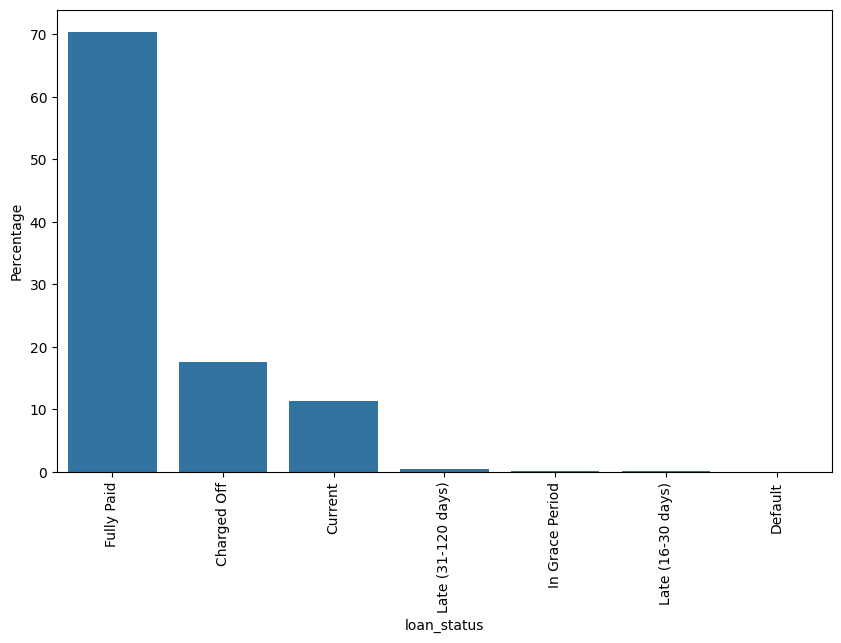

In [78]:
view_cat_plot(df_loan,'loan_status',rotate=True)

### Select binary classitication: "Fully Paid" and "Charged Off"

In [79]:
#df[df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')}
df=df_loan.loc[df_loan['loan_status'].isin(['Fully Paid','Charged Off'])]

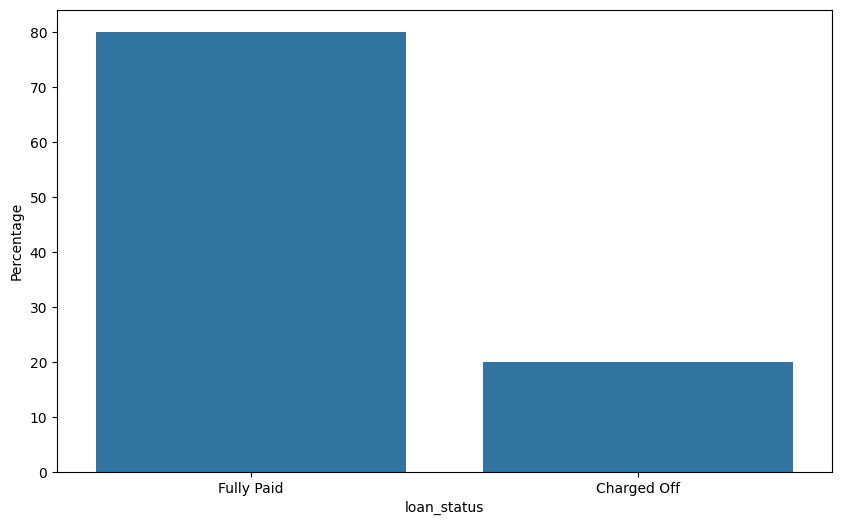

In [80]:
view_cat_plot(df,'loan_status')

### Target variable is imbalance:
* May need to use SMOTE from imblearn.over_sampling to balance the target variable
* May need to optimize the threshold in binary classification

### Convert target variable to numeric
#### Need to predict 1 for Charged Of and 0 for not Charged Off

In [81]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0,'Charged Off':1})

# Feature Selection/Engneering: Dimensionality Reduction
* **Missing data**
    * Drop feature if missiing value is greater than **MV_FEATURE*100** percent
    * Drop the sample observations with NaN value (approx 12 percent.) or replace NaN with mean or median   
* **Categorical varaibles**
    * Ordinal: Convert ordinal to numeric type
    * Nominal: Drop features if number of categories exceed **CV_MAX**
* **Pairwise correlations**
    * Drop highly pairwise correlated feature to avoid multicollinearity (correlation > **PC_MAX**)

### Adjust the following variables to improve the performance of the model

In [82]:
# Drop feature if missiing value is MV_FEATURE*100 percent
MV_FEATURE = 0.5

# Drop categorical feature if the number of categories exceeds
CV_MAX = 55

# Drop one of the features if a pairwise correlation is greater than PC_MAX
PC_MAX=0.95

### Dealing with missing data

In [83]:
df_null = pd.DataFrame({'Count': df.isna().sum(),'Percent': df.isna().mean()*100})

In [84]:
df_null_filtered = df_null[df_null['Percent'] > 5].sort_values(by='Percent',ascending=False)

<Axes: xlabel='Percent', ylabel='None'>

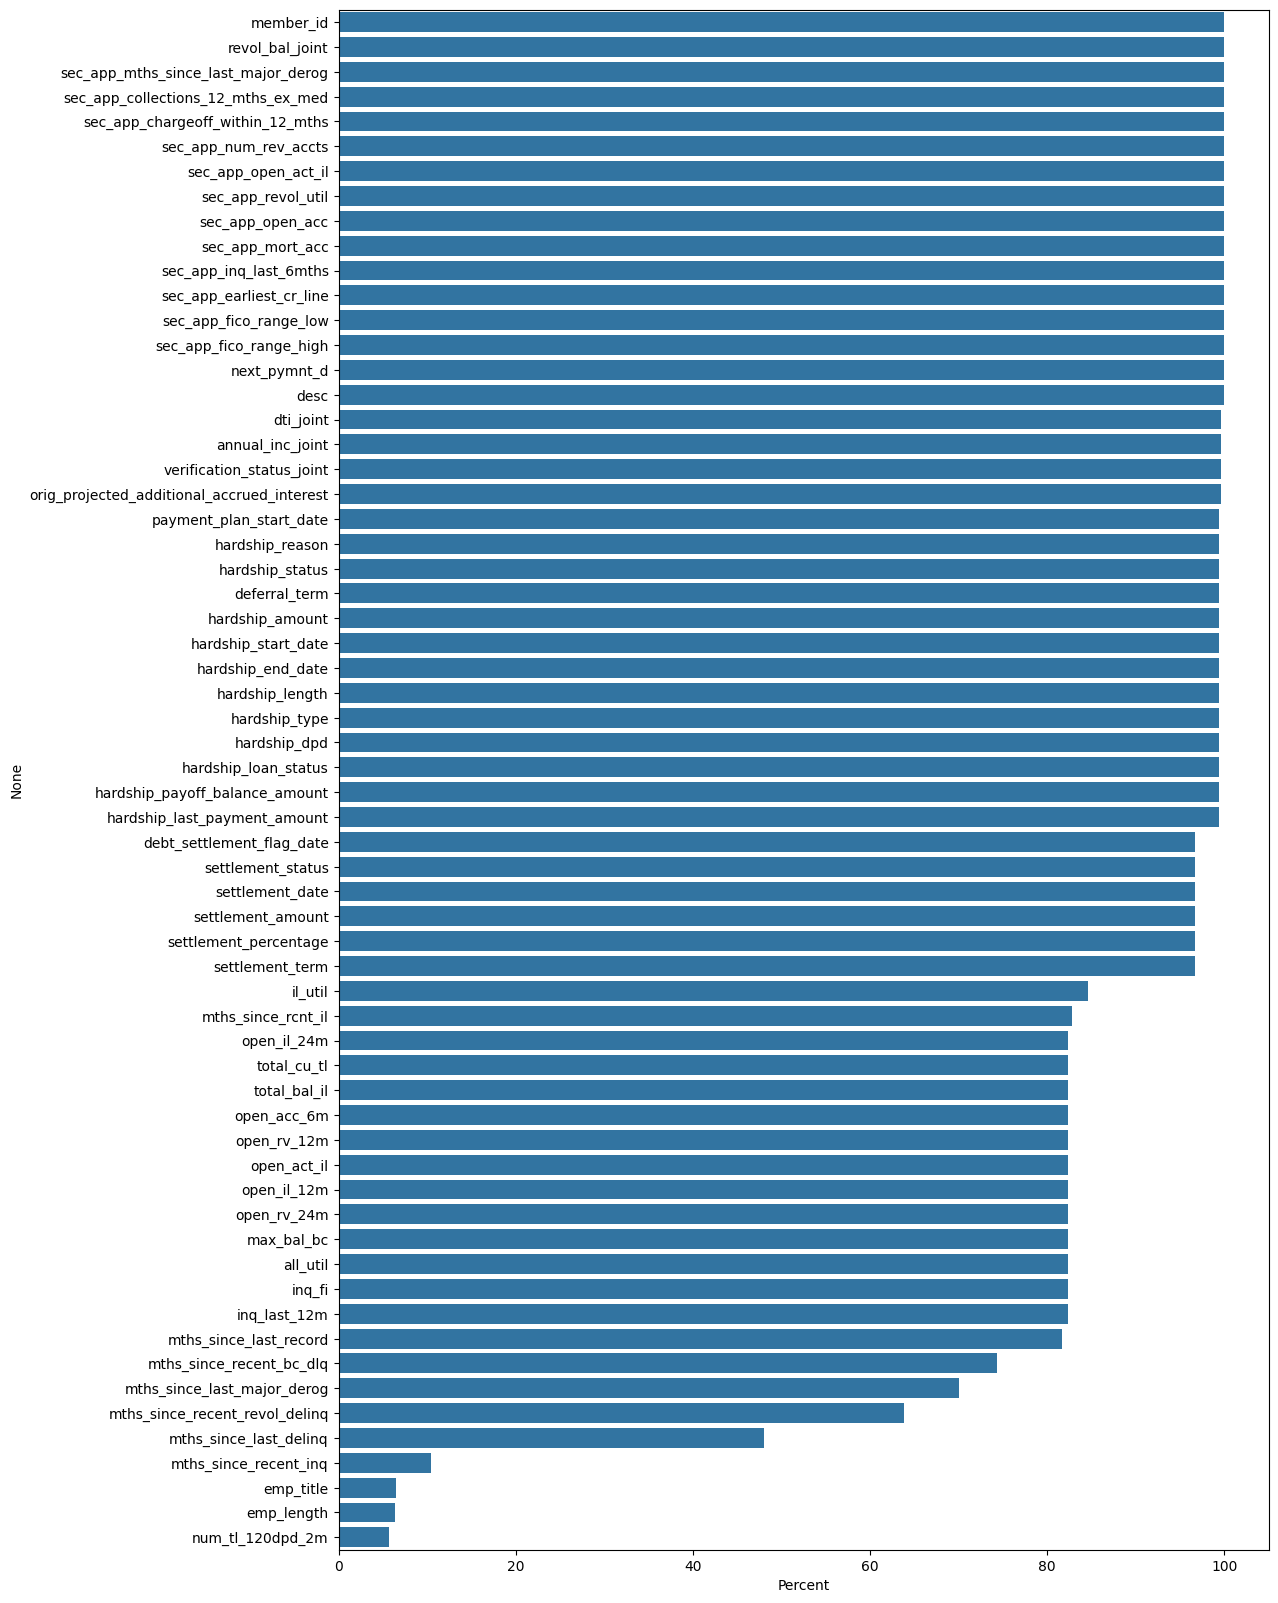

In [85]:
plt.figure(figsize=(12,20))
sns.barplot(x='Percent',y=df_null_filtered.index,data=df_null_filtered)

###### There are no features with missing values in between 20-50%. So, any features with missing values greater than 50% may not be available to the lender most of the time.

#### Drop any features with more missing values


In [86]:
df.dropna(axis=1,thresh=int(MV_FEATURE*len(df_loan)),inplace=True)

In [87]:
df.shape

(107135, 93)

In [88]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'a

In [89]:
# earliest_cr_line need to change to numeric variables
earliest_cr_line = df_loan['earliest_cr_line'].astype('datetime64[ns]')
issue_d = df_loan['issue_d'].astype('datetime64[ns]')
df['earliest_cr_line'] = (issue_d.dt.year-earliest_cr_line.dt.year)*12 + (issue_d.dt.month-earliest_cr_line.dt.month)

## Data leakage known as future data
### List of variable that are not available while taking the decision to lend the costumer

In [90]:
features_not_available = ['funded_amnt','funded_amnt_inv','installment','issue_d','out_prncp',
                         'out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
                         'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                         'last_credit_pull_d','last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med',
                        'disbursement_method','debt_settlement_flag']


In [91]:
dictionary.loc[features_not_available]

,description
feature,
funded_amnt,The total amount committed to that loan at that point in time.
funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
installment,The monthly payment owed by the borrower if the loan originates.
issue_d,The month which the loan was funded
out_prncp,Remaining outstanding principal for total amount funded
out_prncp_inv,Remaining outstanding principal for portion of total amount funded by investors
total_pymnt,Payments received to date for total amount funded
total_pymnt_inv,Payments received to date for portion of total amount funded by investors
total_rec_prncp,Principal received to date


In [92]:
df = df.drop(features_not_available,axis=1)

In [93]:
# Fraction of samples with matimum missing value
frac_nan = df.isna().sum().max()/len(df)
print(f'NaN sample obervations: {(frac_nan*100):g}%.')

NaN sample obervations: 10.4905%.


#### We do have a large sample. So, drop any rows with NaN value.

In [94]:
df.dropna(inplace=True)

In [95]:
print(f'We do have {str(df.shape[0])[:-3]}k obserbations remaining for further processing.')

We do have 81k obserbations remaining for further processing.


# Catagorical variables

In [96]:
df_object = df.select_dtypes(['object'])

In [97]:
df_object.nunique().sort_values(ascending=False)

,0
url,81215
emp_title,33164
zip_code,875
addr_state,49
sub_grade,35
title,14
purpose,12
emp_length,11
grade,7
home_ownership,4


### Dorp features with many catagories > CV_MAX  or single catatory
##### For example, ID  and url features are not relevant

In [98]:
drop_list_not_relevent = list(df_object.nunique()[(df_object.nunique()>CV_MAX) | (df_object.nunique() == 1)].index)

In [99]:
df.drop(labels=drop_list_not_relevent,axis=1,inplace=True)

In [100]:
df.select_dtypes(['object']).nunique()

,0
term,2
grade,7
sub_grade,35
emp_length,11
home_ownership,4
verification_status,3
purpose,12
title,14
addr_state,49
initial_list_status,2


## Let's investigate the categorical variables

### Term

In [101]:
df['term'].value_counts()

,count
term,
36 months,61115
60 months,20100


In [132]:
df['term']=df['term'].apply(lambda tm: np.int8(tm.split()[0]) if isinstance(tm, str) else np.nan)

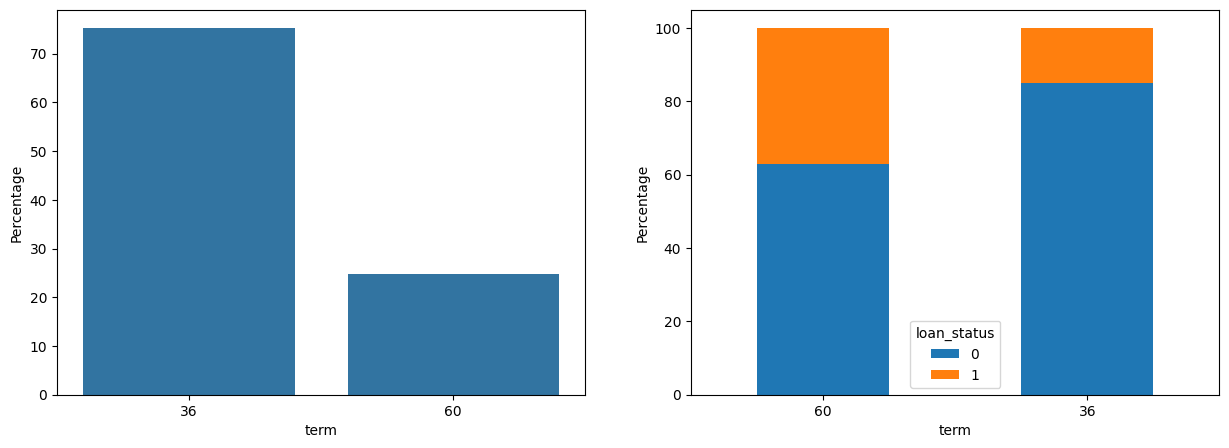

In [103]:
view_cat_target_plot(df,'term')

* Long term involves more risk than short term.

### Grade

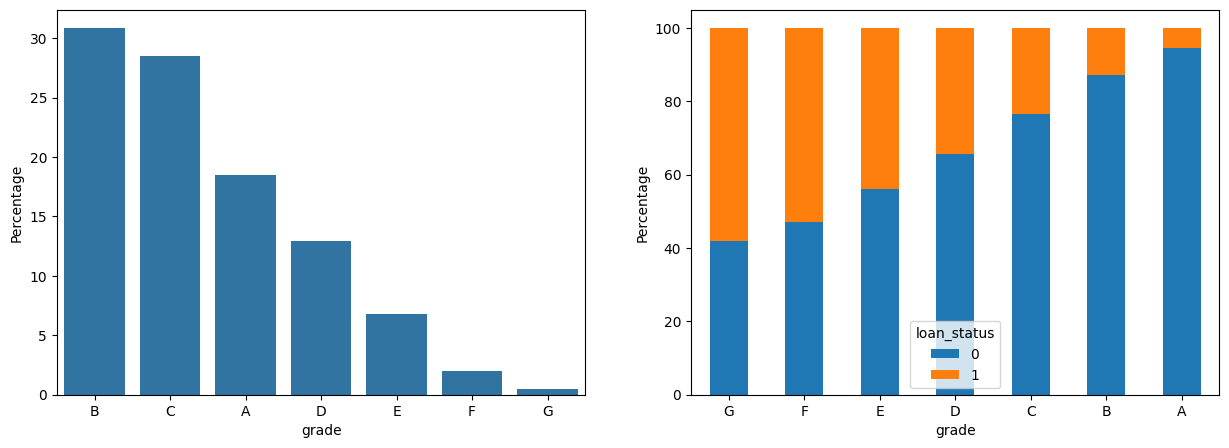

In [104]:
view_cat_target_plot(df,'grade')

* Many borrowers do have grade B and few do have grade G.
* Grade are graded from A (lowest risk/lowest rate) to G (highest risk/highest rate), with subgrades per rate.
* In latest data, Lending Club has removed F and G grade because of hight refaults rate.

### Employ Length

In [105]:
df['emp_length'].value_counts()

,count
emp_length,
10+ years,28431
2 years,7691
< 1 year,7472
3 years,7065
1 year,5777
5 years,5196
4 years,5077
8 years,4471
6 years,3431


##### Convert ordinal catgory to numeric type

In [106]:
df['emp_length'].replace(to_replace=['10+ years','< 1 year'],value=['10 years','0 year'],inplace=True)

In [107]:
df['emp_length'] = df['emp_length'].apply(lambda year: np.int8(year.split()[0]) if type(year) == str else np.nan )

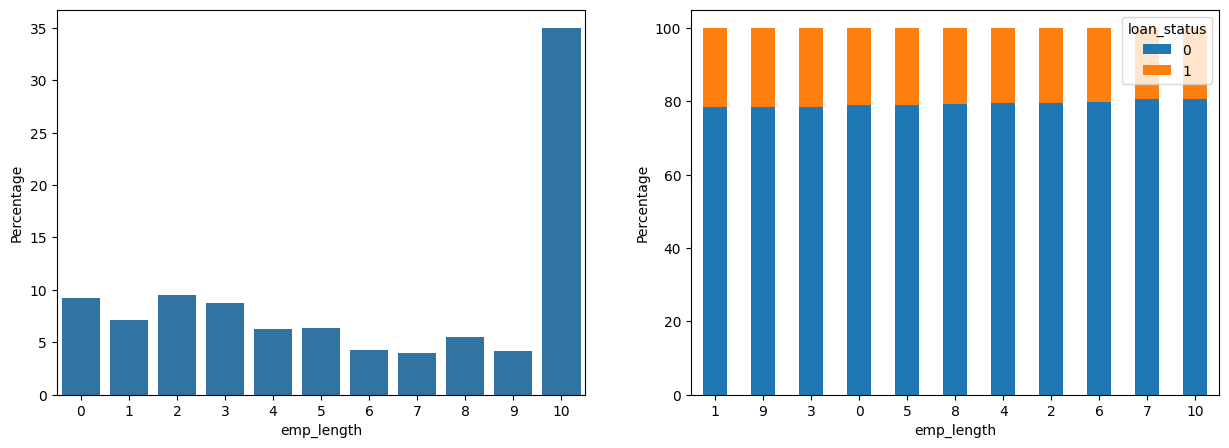

In [108]:
view_cat_target_plot(df,'emp_length')

### Home Ownership

In [109]:
df['home_ownership'].value_counts()

,count
home_ownership,
MORTGAGE,40720
RENT,31921
OWN,8573
ANY,1


In [110]:
df['home_ownership'].replace(['ANY','NONE'],'OTHER',inplace=True)

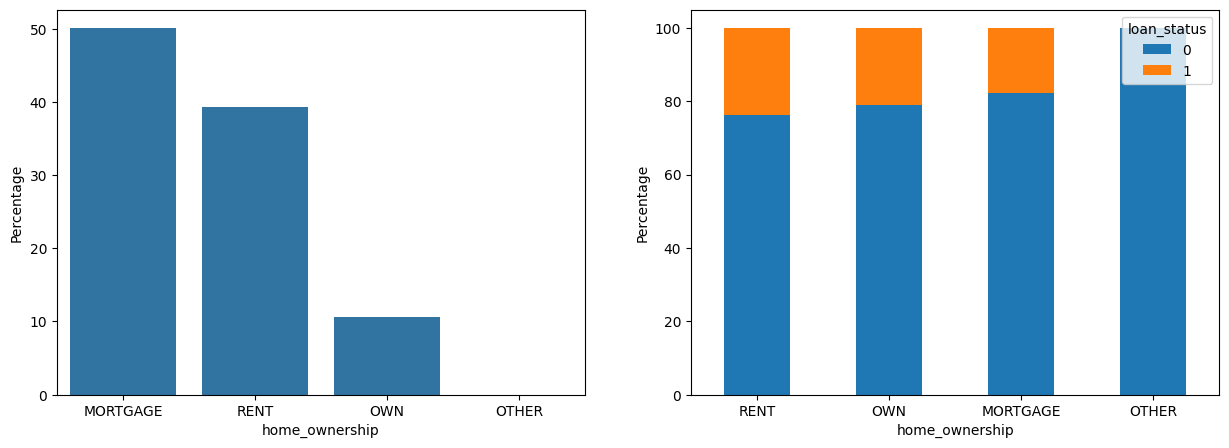

In [111]:
view_cat_target_plot(df,'home_ownership')

### Varification status

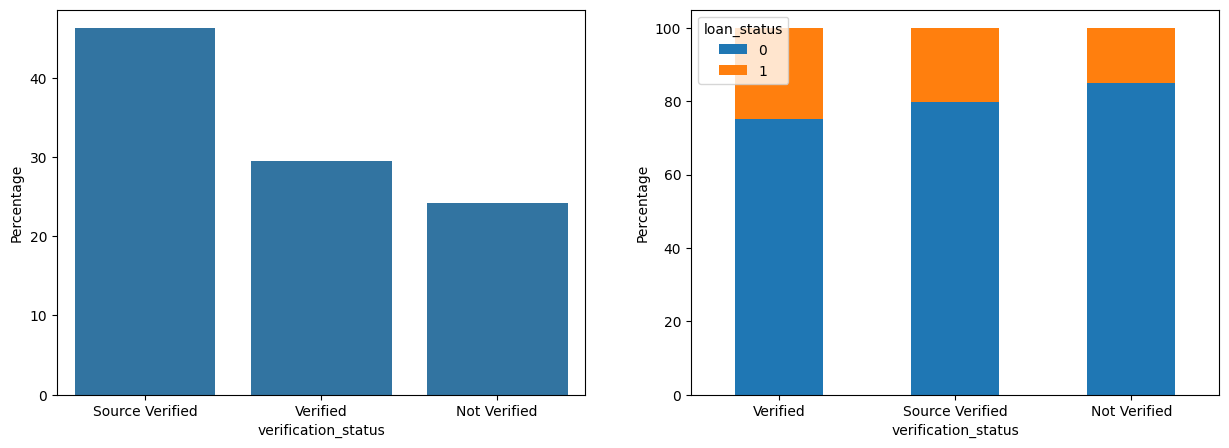

In [112]:
view_cat_target_plot(df,'verification_status')

## Purpose

In [113]:
df['purpose'].value_counts()

,count
purpose,
debt_consolidation,46379
credit_card,19845
home_improvement,5349
other,4288
major_purchase,1645
medical,956
small_business,742
car,736
moving,475


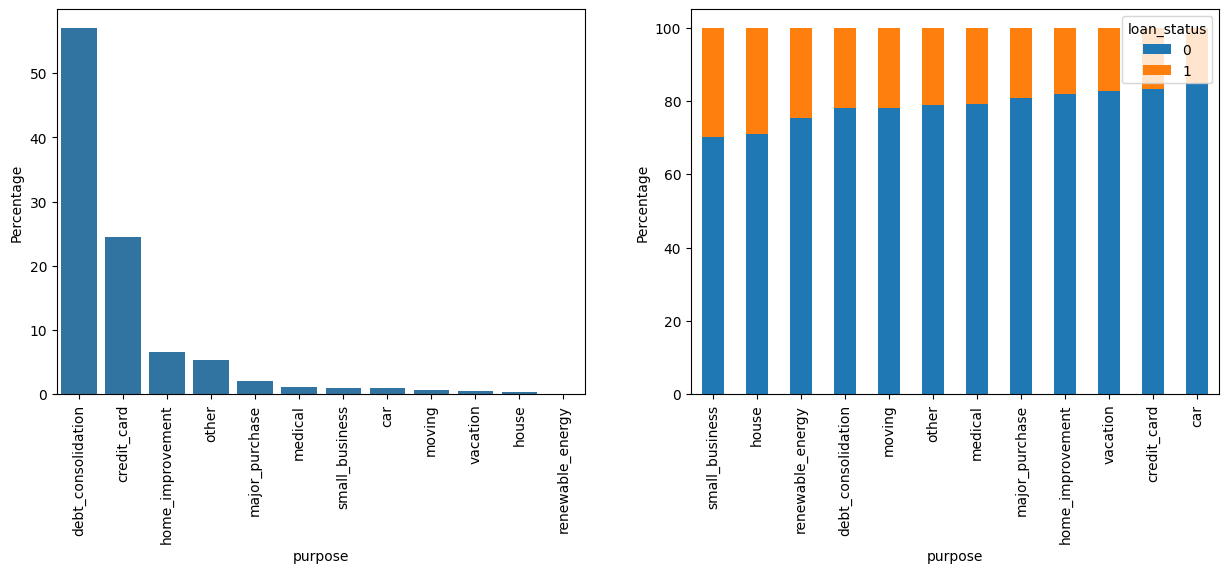

In [114]:
view_cat_target_plot(df,'purpose',rotate_index=90)

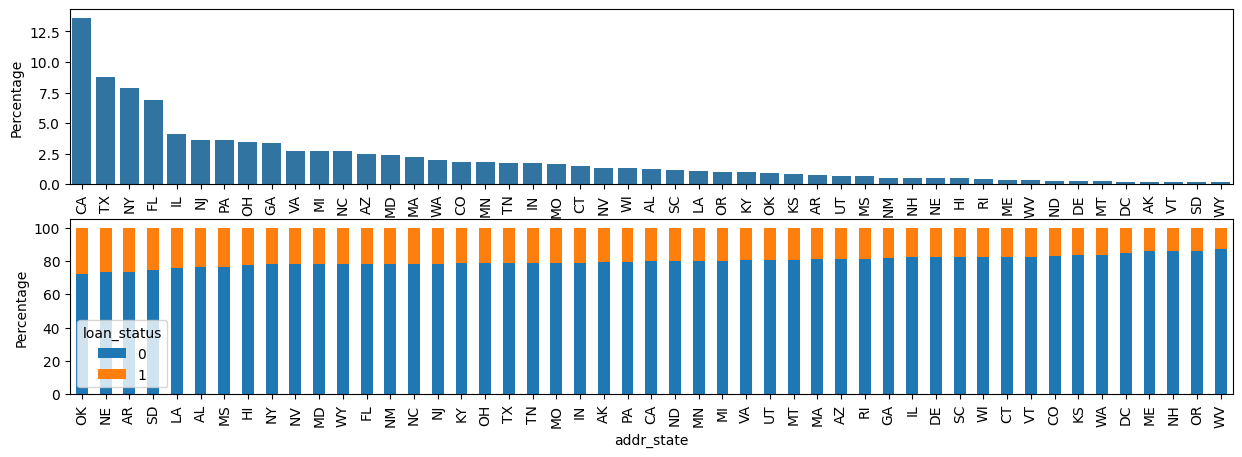

In [115]:
view_cat_target_plot(df,'addr_state',rotate_index=90,sub_plots=(2,1))

## Pairwise correlation

In [116]:
df['fico_range_low'].corr(df['fico_range_high'])

0.9999999349383427

In [117]:
df['fico_score'] = (df['fico_range_low']+ df['fico_range_high'])/2.0

In [118]:
df.drop(['fico_range_low','fico_range_high'],inplace=True,axis=1)

In [119]:
#Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'title', 'addr_state', 'initial_list_status',
       'application_type'],
      dtype='object')


In [120]:
# Remove non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

In [121]:
corr_stack = df_numeric.corr().stack()
corr = corr_stack[corr_stack.index.get_level_values(0) != corr_stack.index.get_level_values(1)]

In [122]:
pair_corr_high = corr[corr > PC_MAX]
pair_corr_high

,,0
open_acc,num_sats,0.999355
tot_cur_bal,tot_hi_cred_lim,0.985215
num_actv_rev_tl,num_rev_tl_bal_gt_0,0.995319
num_rev_tl_bal_gt_0,num_actv_rev_tl,0.995319
num_sats,open_acc,0.999355
tot_hi_cred_lim,tot_cur_bal,0.985215


In [123]:
# dropping ALL duplicte values
drop_pair_list = pair_corr_high.drop_duplicates().index.get_level_values(1).unique()
print(f'Dropped following highly pairwise correlated features:\n {drop_pair_list.values}')

Dropped following highly pairwise correlated features:
 ['num_sats' 'tot_hi_cred_lim' 'num_rev_tl_bal_gt_0']


In [124]:
df.drop(drop_pair_list,axis=1,inplace=True)

## Exploratory data analysis for a few sample numeric valriables

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

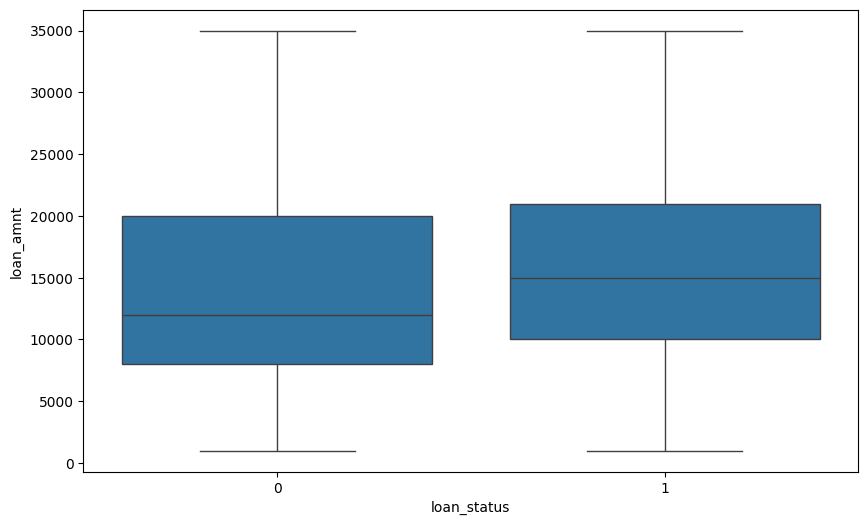

In [125]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

In [126]:
#sns.boxplot(x='loan_status',y='last_fico_range_high',data=df)

<Axes: xlabel='loan_status', ylabel='int_rate'>

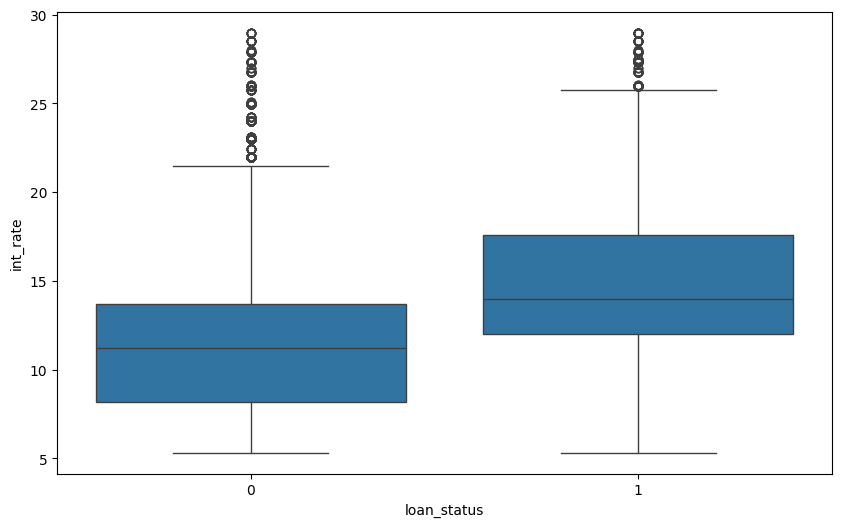

In [127]:
sns.boxplot(x='loan_status',y='int_rate',data=df)

<Axes: xlabel='loan_status', ylabel='fico_score'>

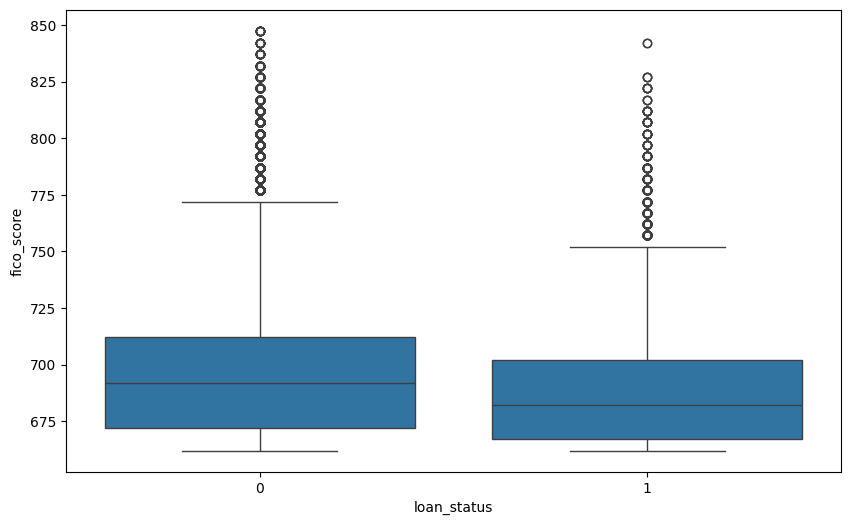

In [128]:
sns.boxplot(x='loan_status',y='fico_score',data=df)

In [129]:
print(f'{df.shape[1]} selected fetures names: \n {df.columns.values}')

64 selected fetures names: 
 ['id' 'loan_amnt' 'term' 'int_rate' 'grade' 'sub_grade' 'emp_length'
 'home_ownership' 'annual_inc' 'verification_status' 'loan_status'
 'purpose' 'title' 'addr_state' 'dti' 'delinq_2yrs' 'earliest_cr_line'
 'inq_last_6mths' 'open_acc' 'pub_rec' 'revol_bal' 'revol_util'
 'total_acc' 'initial_list_status' 'last_pymnt_amnt' 'policy_code'
 'application_type' 'acc_now_delinq' 'tot_coll_amt' 'tot_cur_bal'
 'total_rev_hi_lim' 'acc_open_past_24mths' 'avg_cur_bal' 'bc_open_to_buy'
 'bc_util' 'chargeoff_within_12_mths' 'delinq_amnt' 'mo_sin_old_il_acct'
 'mo_sin_old_rev_tl_op' 'mo_sin_rcnt_rev_tl_op' 'mo_sin_rcnt_tl'
 'mort_acc' 'mths_since_recent_bc' 'mths_since_recent_inq'
 'num_accts_ever_120_pd' 'num_actv_bc_tl' 'num_actv_rev_tl' 'num_bc_sats'
 'num_bc_tl' 'num_il_tl' 'num_op_rev_tl' 'num_rev_accts'
 'num_tl_120dpd_2m' 'num_tl_30dpd' 'num_tl_90g_dpd_24m'
 'num_tl_op_past_12m' 'pct_tl_nvr_dlq' 'percent_bc_gt_75'
 'pub_rec_bankruptcies' 'tax_liens' 'total_bal_ex_m

In [130]:
print(f'Final data contains {str(df.shape[0])[:-3]}k observations and {df.shape[1]} features.')

Final data contains 81k observations and 64 features.


### write processed data to the file

In [131]:
df.to_csv('loan_data_final_'+str(PC_MAX)+'.csv',index=None)